In [2]:
# ==== ParlaMint-PT loader (all years) → clean text → align with metadata ====

import os, glob, re
import pandas as pd

# ---- EDIT THIS: your root folder that contains the year subfolders ----
ROOT_DIR = "/Users/simon/Desktop/ParlaMintPTtext.txt"   # your working path

# (optional) where to save merged results
OUT_PARQUET = None  # e.g., "/Users/simon/Desktop/parlamint_pt_all.parquet"

def discover_pairs(root_dir):
    """
    Find all TXT + -meta.tsv pairs recursively under root_dir.
    Returns list of tuples: (date_iso, txt_path, meta_path)
    """
    pattern = os.path.join(root_dir, "**", "ParlaMint-PT_*.txt")
    txt_files = sorted(glob.glob(pattern, recursive=True))
    pairs = []
    for txt in txt_files:
        meta = txt[:-4] + "-meta.tsv"  # non-EN meta next to the txt
        if os.path.exists(meta):
            m = re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(txt))
            date_iso = m.group(1) if m else ""
            pairs.append((date_iso, txt, meta))
    return pairs

ID_PREFIX_RE = re.compile(r'^\s*(ParlaMint-PT_\d{4}-\d{2}-\d{2}\.[^\t]*)\t')

def parse_text_line(raw_line: str):
    """
    Split a raw line into (utt_id, clean_text).
    - Lines typically look like: 'ParlaMint-PT_2015-01-07.u1\tSrs. Deputados, ...'
    - If no tab/id found, utt_id is '', clean_text is the trimmed line.
    """
    m = ID_PREFIX_RE.match(raw_line)
    if m:
        utt_id = m.group(1)
        clean_text = raw_line[m.end():].strip()
        return utt_id, clean_text
    else:
        # fallback: if there is a tab, split once
        if "\t" in raw_line:
            left, right = raw_line.split("\t", 1)
            return left.strip(), right.strip()
        return "", raw_line.strip()

def load_one_day(txt_path, meta_path, date_iso):
    """
    Load one day's TXT and META into DataFrames:
      - texts_df: date, line_no, utt_id, text
      - meta_df : original meta (adds 'date' if missing)
    """
    with open(txt_path, "r", encoding="utf-8") as f:
        raw_lines = [ln.rstrip("\n") for ln in f]

    utt_ids, clean_texts = [], []
    for ln in raw_lines:
        uid, ct = parse_text_line(ln)
        utt_ids.append(uid)
        clean_texts.append(ct)

    texts_df = pd.DataFrame({
        "date": date_iso,
        "line_no": range(1, len(clean_texts) + 1),
        "utt_id": utt_ids,
        "text": clean_texts
    })

    meta_df = pd.read_csv(meta_path, sep="\t", dtype=str).fillna("")
    # ensure a date column exists
    if "date" not in (c.lower() for c in meta_df.columns):
        meta_df["date"] = date_iso

    return texts_df, meta_df

# ---- Load everything ----
pairs = discover_pairs(ROOT_DIR)
print(f"Found {len(pairs)} days with TXT + meta")

texts_all, meta_all = [], []
for date_iso, txt, meta in pairs:
    tdf, mdf = load_one_day(txt, meta, date_iso)
    texts_all.append(tdf)
    meta_all.append(mdf)

texts_df = pd.concat(texts_all, ignore_index=True)
meta_df  = pd.concat(meta_all,  ignore_index=True)

print("All texts_df shape:", texts_df.shape)
print("All meta_df  shape:", meta_df.shape)

# ---- Align by index (same order built in the same loop) ----
# Keep only one 'date' column (from texts_df)
full_df = pd.concat(
    [texts_df.reset_index(drop=True),
     meta_df.reset_index(drop=True).drop(columns=["date"], errors="ignore")],
    axis=1
)

print("\nfull_df shape:", full_df.shape)
print(full_df.head(10))

# ---- (optional) Save to Parquet for fast future use ----
if OUT_PARQUET:
    full_df.to_parquet(OUT_PARQUET, index=False)
    print(f"\nSaved merged data to: {OUT_PARQUET}")

Found 901 days with TXT + meta
All texts_df shape: (248577, 4)
All meta_df  shape: (248577, 24)

full_df shape: (248577, 28)
         date  line_no                       utt_id  \
0  2015-01-07        1   ParlaMint-PT_2015-01-07.u1   
1  2015-01-07        2   ParlaMint-PT_2015-01-07.u2   
2  2015-01-07        3   ParlaMint-PT_2015-01-07.u3   
3  2015-01-07        4   ParlaMint-PT_2015-01-07.u4   
4  2015-01-07        5   ParlaMint-PT_2015-01-07.u5   
5  2015-01-07        6   ParlaMint-PT_2015-01-07.u6   
6  2015-01-07        7   ParlaMint-PT_2015-01-07.u7   
7  2015-01-07        8   ParlaMint-PT_2015-01-07.u8   
8  2015-01-07        9   ParlaMint-PT_2015-01-07.u9   
9  2015-01-07       10  ParlaMint-PT_2015-01-07.u10   

                                                text                  Text_ID  \
0  Srs. Deputados, Srs. Jornalistas, Srs. Funcion...  ParlaMint-PT_2015-01-07   
1  Sr.ª Presidente, Srs. Deputados, deram entrada...  ParlaMint-PT_2015-01-07   
2  Muito obrigada, Sr. Dep

In [35]:
#Just for testing if it works (so you can skip this
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
#import torch

#MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Force anonymous access: token=None prevents sending any Authorization header
#tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token=None)
#model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, token=None)

#device = 0 if torch.cuda.is_available() else -1
#sentiment = pipeline(
#    "sentiment-analysis",
 #   model=model,
  #  tokenizer=tokenizer,
   # device=device,
    #return_all_scores=True
#)

# quick sanity check
#print(sentiment("Isto é fantástico!"))   # should be positive-ish
#print(sentiment("Isto é horrível."))     # should be negative-ish

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cpu


[[{'label': 'negative', 'score': 0.0350860133767128}, {'label': 'neutral', 'score': 0.05009797215461731}, {'label': 'positive', 'score': 0.9148160815238953}]]
[[{'label': 'negative', 'score': 0.9615845680236816}, {'label': 'neutral', 'score': 0.022768916562199593}, {'label': 'positive', 'score': 0.01564646326005459}]]


In [ ]:
# ============================================
# ParlaMint-PT sentiment (MPS, plain tqdm bar, checkpoints)
# ============================================

import os, warnings
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm  # <-- console/text bar (no ipywidgets needed)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# ---------- config ----------
MODEL_NAME   = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
TEXT_COL     = "text"
MAX_TOKENS   = 224      # try 192 for more speed, 256 for a bit more context
OVERLAP      = 16
BATCH_SIZE   = 96       # bump down if memory is tight (64/48)

CHECKPOINT_CSV = None   # e.g., "/Users/simon/Desktop/parlamint_pt_scored_checkpoint.csv"
SAVE_EVERY     = 10_000 # checkpoint interval
FINAL_CSV      = None   # e.g., "/Users/simon/Desktop/parlamint_pt_scored.csv"
FINAL_PARQUET  = None   # e.g., "/Users/simon/Desktop/parlamint_pt_scored.parquet"

# ---------- sanity ----------
assert "full_df" in globals(), "Please create 'full_df' first."
assert TEXT_COL in full_df.columns, f"'{TEXT_COL}' not in full_df."

# remove any stray HF tokens (public model; avoid 401s)
for k in ("HF_TOKEN","HUGGINGFACEHUB_API_TOKEN","HUGGING_FACE_HUB_TOKEN"):
    os.environ.pop(k, None)

# keep output tidy
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# ---------- device ----------
device_str = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16 if device_str in {"mps","cuda"} else torch.float32
print("Using device:", device_str)

# ---------- model + pipeline ----------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token=None)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, torch_dtype=dtype, token=None).to(device_str)

# return all class scores; no truncation flag (we chunk ourselves)
sentiment = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
)

# ---------- helpers ----------
def chunk_by_tokens(text, tokenizer, max_tokens=MAX_TOKENS, overlap=OVERLAP):
    t = (text or "").strip()
    if not t: return []
    ids = tokenizer(t, add_special_tokens=False)["input_ids"]
    if len(ids) <= max_tokens: return [t]
    out, s = [], 0
    while s < len(ids):
        e = min(s + max_tokens, len(ids))
        out.append(tokenizer.decode(ids[s:e], skip_special_tokens=True))
        if e == len(ids): break
        s = max(0, e - overlap)
    return out

def normalize(scores):
    # [{'label':'NEGATIVE','score':..}, {'label':'NEUTRAL',..}, {'label':'POSITIVE',..}]
    m = {d["label"].lower(): float(d["score"]) for d in scores}
    pn, pe, pp = m.get("negative",0.0), m.get("neutral",0.0), m.get("positive",0.0)
    s = pn + pe + pp
    if s: pn, pe, pp = pn/s, pe/s, pp/s
    return pn, pe, pp

def predict_chunks(chunks):
    if not chunks: return []
    out = sentiment(chunks, batch_size=BATCH_SIZE)  # pipeline handles batching
    return [normalize(scores) for scores in out]

@torch.inference_mode()
def score_one_speech(text):
    t = (text or "").strip()
    if not t:
        return {"p_neg":0.0,"p_neu":1.0,"p_pos":0.0,"sent_score":0.0,"sent_label":"neutral"}
    chunks = chunk_by_tokens(t, tokenizer)
    if len(chunks) == 1:
        pn, pe, pp = predict_chunks(chunks)[0]
    else:
        # weight by token length per chunk
        w = np.array([len(tokenizer(ch, add_special_tokens=False)["input_ids"]) for ch in chunks], float)
        w /= w.sum()
        probs = predict_chunks(chunks)
        pn = float(np.sum([probs[i][0]*w[i] for i in range(len(probs))]))
        pe = float(np.sum([probs[i][1]*w[i] for i in range(len(probs))]))
        pp = float(np.sum([probs[i][2]*w[i] for i in range(len(probs))]))
    lab = ["negative","neutral","positive"][np.argmax([pn,pe,pp])]
    return {"p_neg":pn,"p_neu":pe,"p_pos":pp,"sent_score":pp - pn,"sent_label":lab}

# ---------- warm-up (lets MPS JIT settle) ----------
_ = predict_chunks(["warmup 1","warmup 2","warmup 3"])

# ---------- main loop with plain text progress bar ----------
results = []
start_idx = 0
n_rows = len(full_df)

# resume from checkpoint if present
if CHECKPOINT_CSV and os.path.exists(CHECKPOINT_CSV):
    try:
        ck = pd.read_csv(CHECKPOINT_CSV)
        if len(ck):
            print(f"Resuming from checkpoint: {len(ck)} rows")
            results = ck.to_dict("records")
            start_idx = len(ck)
    except Exception:
        pass

for i in tqdm(range(start_idx, n_rows), total=n_rows, desc="Scoring speeches", ncols=80):
    res = score_one_speech(full_df.iloc[i][TEXT_COL])
    results.append(res)
    if CHECKPOINT_CSV and (i+1) % SAVE_EVERY == 0:
        pd.DataFrame(results).to_csv(CHECKPOINT_CSV, index=False)

# finalize
sent_df = pd.DataFrame(results)
full_scored = pd.concat([full_df.reset_index(drop=True), sent_df], axis=1)

print("Finished:", full_scored.shape)
cols = [c for c in ["date","speaker","party","sent_label","sent_score"] if c in full_scored.columns]
print(full_scored[cols].head(10))

# optional saves
if FINAL_CSV:
    full_scored.to_csv(FINAL_CSV, index=False)
    print("Saved CSV →", FINAL_CSV)
if FINAL_PARQUET:
    try:
        full_scored.to_parquet(FINAL_PARQUET, index=False)
        print("Saved Parquet →", FINAL_PARQUET)
    except Exception as e:
        print("Parquet save failed (install pyarrow/fastparquet). Error:", e)

In [58]:
# Save to Parquet (recommended: smaller, faster)
full_scored.to_parquet("/Users/simon/Desktop/parlamint_pt_scored.parquet", index=False)

Matplotlib is building the font cache; this may take a moment.


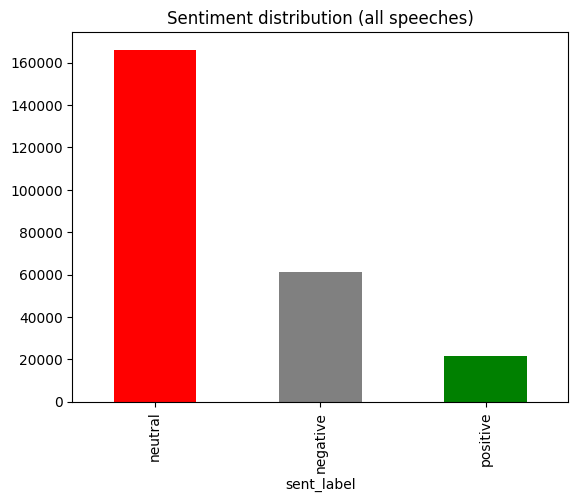

In [60]:
import matplotlib.pyplot as plt

full_scored["sent_label"].value_counts().plot(kind="bar", color=["red","gray","green"])
plt.title("Sentiment distribution (all speeches)")
plt.show()

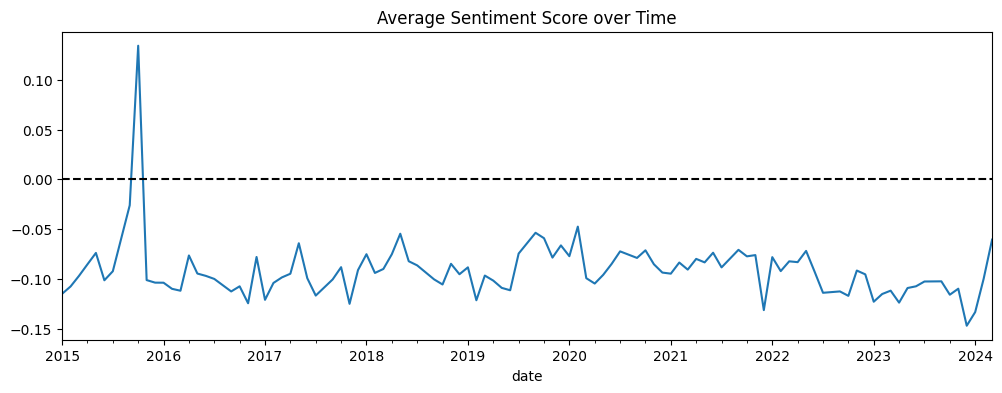

In [62]:
# average sentiment score per month
full_scored["date"] = pd.to_datetime(full_scored["date"])
monthly = full_scored.groupby(full_scored["date"].dt.to_period("M"))["sent_score"].mean()

monthly.plot(figsize=(12,4), title="Average Sentiment Score over Time")
plt.axhline(0, color="black", linestyle="--")
plt.show()

	•	Positive sent_score → more positivity than negativity → language is more approving / optimistic / supportive.
	•	Negative sent_score → more negativity than positivity → language is more critical / disapproving / hostile.
	•	Near zero → balance of neutral or mixed signals.

Top parties by volume:
 party_std
PS        87370
PSD       54501
PCP       29051
BE        25945
CDS-PP    22195
CH        12670
IL         6036
PEV        3782
PAN        3552
L          1924
Name: count, dtype: int64 



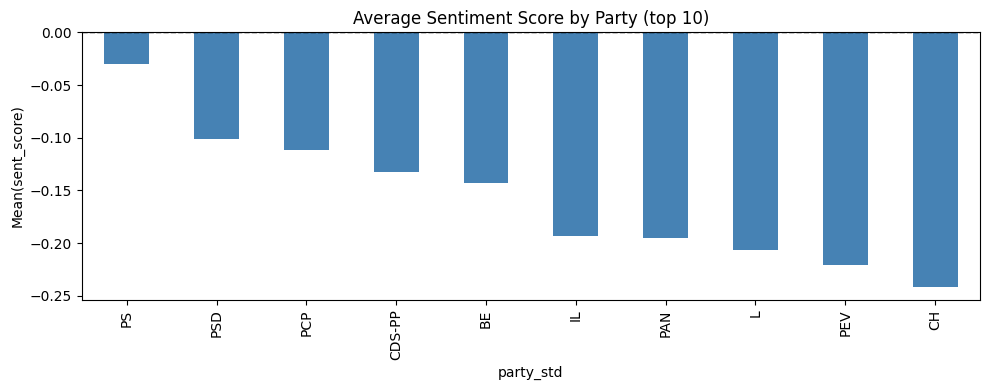

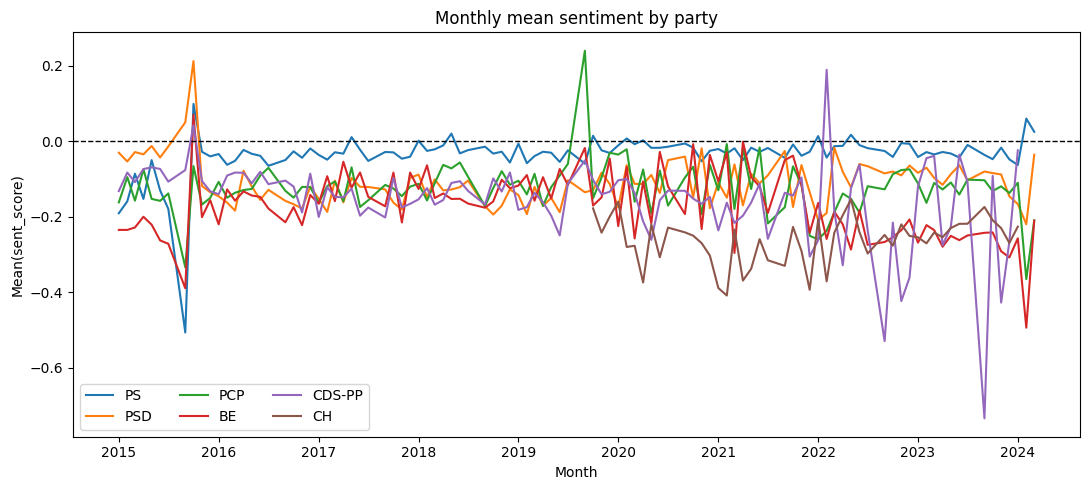

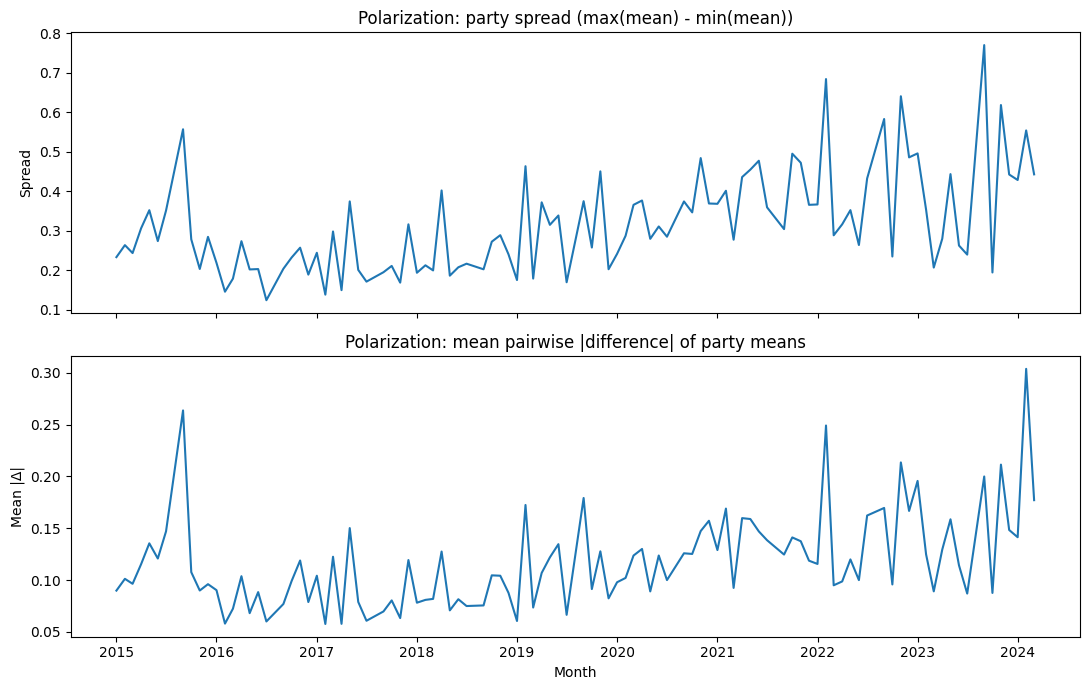

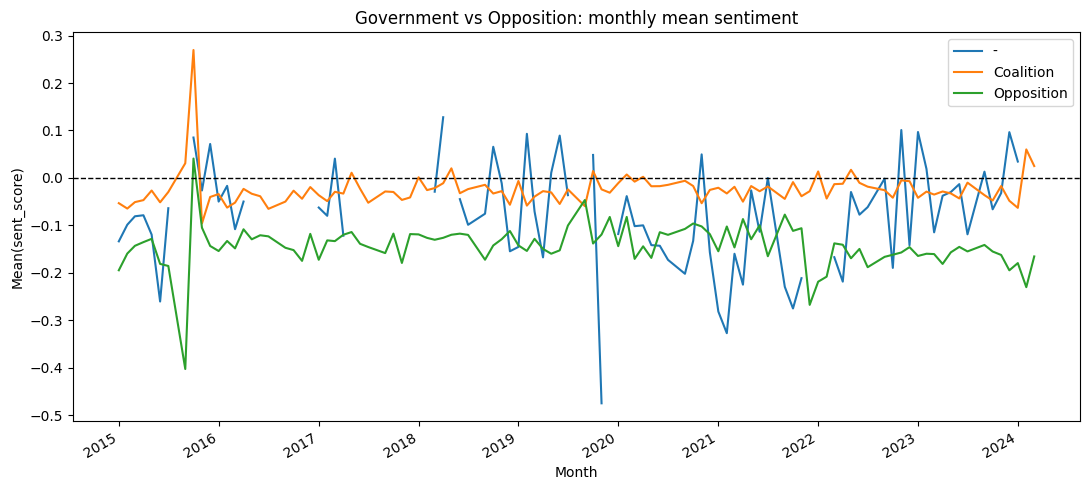

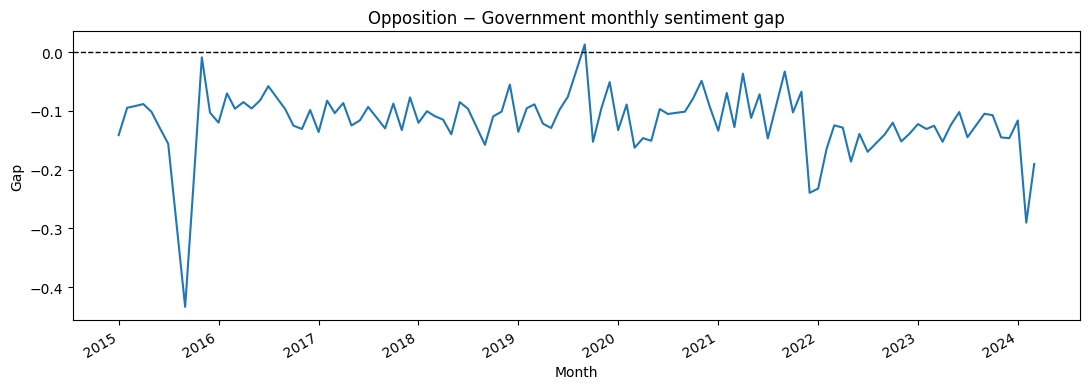

In [66]:
# ========= Party cleaning + trends + polarization for ParlaMint-PT =========
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Use full_scored if present, otherwise fall back to full_df
df = full_scored.copy() if "full_scored" in globals() else full_df.copy()
assert "sent_score" in df.columns, "Run the sentiment scoring first to create 'sent_score'."

# --- 1) Clean party acronyms (from 'Speaker_party': e.g., 'GP-PSD' → 'PSD') ---
def clean_party(x: str) -> str:
    if not isinstance(x, str) or not x.strip():
        return "UNK"
    x = x.strip()
    x = re.sub(r"^GP-", "", x, flags=re.I)     # drop 'GP-' prefix (Grupo Parlamentar)
    x = x.replace("CDS/PP", "CDS-PP")          # normalize
    return x

if "Speaker_party" in df.columns:
    df["party_std"] = df["Speaker_party"].apply(clean_party)
else:
    # fallback via long names if needed
    name2acr = {
        "Grupo Parlamentar do Partido Social Democrata": "PSD",
        "Grupo Parlamentar do Partido Socialista": "PS",
        "Grupo Parlamentar do Bloco de Esquerda": "BE",
        "Grupo Parlamentar do Partido Comunista Português": "PCP",
        "Grupo Parlamentar do Centro Democrático Social – Partido Popular": "CDS-PP",
    }
    df["party_std"] = df.get("Speaker_party_name","").map(name2acr).fillna("UNK")

# Quick look
print("Top parties by volume:\n", df["party_std"].value_counts().head(10), "\n")

# --- 2) Time keys ---
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).reset_index(drop=True)
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# --- 3) Average sentiment by party (top 10) ---
top10 = df["party_std"].value_counts().head(10).index
party_means = (
    df[df["party_std"].isin(top10)]
      .groupby("party_std")["sent_score"]
      .mean()
      .sort_values(ascending=False)
)
ax = party_means.plot(kind="bar", figsize=(10,4), color="steelblue")
ax.set_title("Average Sentiment Score by Party (top 10)")
ax.set_ylabel("Mean(sent_score)"); ax.axhline(0, color="k", lw=1, ls="--")
plt.tight_layout(); plt.show()

# --- 4) Monthly mean sentiment by party ---
monthly_party = (
    df.groupby(["party_std","month"], as_index=False)
      .agg(mean_score=("sent_score","mean"),
           n=("sent_score","size"))
)
wide = monthly_party.pivot(index="month", columns="party_std", values="mean_score").sort_index()

# Plot top 6 parties over time
top6 = df["party_std"].value_counts().head(6).index
sel = [p for p in top6 if p in wide.columns]
plt.figure(figsize=(11,5))
for p in sel:
    plt.plot(wide.index, wide[p], label=p)
plt.axhline(0, color="k", lw=1, ls="--")
plt.title("Monthly mean sentiment by party")
plt.xlabel("Month"); plt.ylabel("Mean(sent_score)")
plt.legend(ncol=3); plt.tight_layout(); plt.show()

# --- 5) Polarization metrics per month ---
def pairwise_mean_abs_diff(vals: np.ndarray) -> float:
    vals = vals[~np.isnan(vals)]
    if len(vals) < 2: return 0.0
    diffs = []
    for i in range(len(vals)):
        for j in range(i+1, len(vals)):
            diffs.append(abs(vals[i]-vals[j]))
    return float(np.mean(diffs))

polar_df = pd.DataFrame({
    "party_spread": wide.max(axis=1) - wide.min(axis=1),        # max(mean) - min(mean) across parties
    "party_std":    wide.std(axis=1, ddof=0),                   # std of party means
    "pairwise_mean_abs_diff": wide.apply(lambda r: pairwise_mean_abs_diff(r.values.astype(float)), axis=1),
}).sort_index()

fig, axes = plt.subplots(2,1, figsize=(11,7), sharex=True)
axes[0].plot(polar_df.index, polar_df["party_spread"])
axes[0].set_title("Polarization: party spread (max(mean) - min(mean))"); axes[0].set_ylabel("Spread")
axes[1].plot(polar_df.index, polar_df["pairwise_mean_abs_diff"])
axes[1].set_title("Polarization: mean pairwise |difference| of party means")
axes[1].set_xlabel("Month"); axes[1].set_ylabel("Mean |Δ|")
plt.tight_layout(); plt.show()

# --- 6) Government vs Opposition (uses Party_status) ---
df["gov_opp"] = (
    df.get("Party_status","").fillna("").replace({"": "Unknown"})
)
gov_month = (
    df.groupby([df["date"].dt.to_period("M").dt.to_timestamp(), "gov_opp"])["sent_score"]
      .mean()
      .unstack()
      .rename_axis(index="month", columns=None)
      .sort_index()
)
ax = gov_month.plot(figsize=(11,5))
ax.axhline(0, color="k", lw=1, ls="--")
ax.set_title("Government vs Opposition: monthly mean sentiment")
ax.set_xlabel("Month"); ax.set_ylabel("Mean(sent_score)")
plt.tight_layout(); plt.show()

# Gap (Opposition - Coalition) if both exist
if {"Opposition","Coalition"}.issubset(set(df["gov_opp"].unique())):
    gap = (gov_month.get("Opposition") - gov_month.get("Coalition")).rename("opp_minus_gov")
    ax = gap.plot(figsize=(11,4), title="Opposition − Government monthly sentiment gap")
    ax.axhline(0, color="k", lw=1, ls="--"); ax.set_xlabel("Month"); ax.set_ylabel("Gap")
    plt.tight_layout(); plt.show()

# --- 7) (Optional) Save tables for your thesis ---
# monthly_party.to_csv("/Users/simon/Desktop/pt_monthly_party_sentiment.csv", index=False)
# polar_df.to_csv("/Users/simon/Desktop/pt_polarization_metrics_monthly.csv")
# gov_month.to_csv("/Users/simon/Desktop/pt_gov_vs_opp_monthly.csv")